<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mln.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mln.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Mixture Logits Network (MLN)

In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from torchvision import datasets,transforms
from collections import OrderedDict
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.5.1].
device:[cuda:0].


## Define the model
- Mixture of Logits (MoL)
- Mixture Logits Network (MLN)

In [2]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

### Mixture of Logits (MoL)

In [3]:
def summarize(name, blocks, x):
    print('='*60)
    print(f'Module [{name}]')
    print(f'\tInput{str(list(x.shape)):>47}')
    with torch.no_grad():
        count_layer = 1
        for i, block in enumerate(blocks):
            x = block(x)
            print(f'\tBlock #{i+1}')
            for layer in block:
                class_name = str(layer.__class__).split(".")[-1].split("'")[0]
                print(f'\t  Layer {f"#{count_layer}":>3} {class_name}')
                count_layer += 1
            print(f'{str(list(x.shape)):>60}')
            
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = None
        self.blocks = None
    def build_graph(self, blocks):
        return nn.ModuleList(map(lambda block: nn.Sequential(*block), blocks))
    def __validate(self):
        assert self.name,   '`self.name` is not defined'
        assert self.blocks, '`self.blocks` is not defined. Build one using self.build_graph(blocks)'
    def summarize(self, x):
        self.__validate()
        summarize(self.name, self.blocks, x) 
    def forward(self, x):
        self.__validate()
        for block in self.blocks:
            x = block(x)
        return x

class Extracter(BaseModel):
    def __init__(self, name='Feature Extracter'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(32),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
            )
        ]
        self.blocks = self.build_graph(blocks)
        
class ModelMuSigma(BaseModel):
    def __init__(self, dim_k, name='MoL MuSigma'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                nn.InstanceNorm2d(32),
                nn.ReLU(inplace=True),
            ), (    
                nn.ConvTranspose2d(32, dim_k, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            ),
        ]
        self.blocks = self.build_graph(blocks) 

class ModelPi(BaseModel):
    def __init__(self, dim_k, name='MoL Pi'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(128),
                nn.LeakyReLU(.2, inplace=True),
            ), (    
                nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(128),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(256),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Conv2d(256, dim_k//2, kernel_size=5, stride=5, padding=0, bias=True),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Flatten(),
                nn.Softmax(1),
            )
        ]
        self.blocks = self.build_graph(blocks) 

### Mixture Logits Network (MLN)

In [4]:
class MixtureLogitsNetwork(nn.Module):
    def __init__(self,
                 dim_k      = 10,
                 # todo: multi class를 위한 dim_y 추가, SHARE_SIG도 추가
                 sig_min    = 1e-4, 
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                ):
        super().__init__()
        self.dim_k   = dim_k
        self.sig_min = sig_min
        self.mu_min  = mu_min
        self.mu_max  = mu_max
        self.build_graph()
        self.init_param() 
    def build_graph(self):
        self.extracter   = Extracter()
        self.model_pi    = ModelPi(dim_k=self.dim_k)
        self.model_mu    = ModelMuSigma(dim_k=self.dim_k, name='MoL Mu')
        self.model_sigma = ModelMuSigma(dim_k=self.dim_k, name='MoL Sigma')
    def init_param(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        list(self.model_mu.modules())[-1].bias.data.uniform_(self.mu_min,self.mu_max)
    def summarize(self, x):
        self.extracter.summarize(x)
        with torch.no_grad():
            f = self.extracter(x)
        self.model_pi.summarize(f)
        self.model_mu.summarize(f)
        self.model_sigma.summarize(f)
    def forward(self, x):
        f     = self.extracter(x)
        
        pi    = self.model_pi(f)
        mu    = self.model_mu(f)
        sigma = self.sig_min + torch.exp(self.model_sigma(f))
        return {'pi': pi, 'mu': mu, 'sigma': sigma}

x = torch.randn(4, 3, 180, 320)  # demo [N x C x H x W]
mln = MixtureLogitsNetwork()
mln.summarize(x)

Module [Feature Extracter]
	Input                               [4, 3, 180, 320]
	Block #1
	  Layer  #1 Conv2d
	  Layer  #2 InstanceNorm2d
	  Layer  #3 ReLU
                                            [4, 32, 90, 160]
	Block #2
	  Layer  #4 Conv2d
	  Layer  #5 ReLU
                                             [4, 64, 45, 80]
Module [MoL Pi]
	Input                                [4, 64, 45, 80]
	Block #1
	  Layer  #1 Conv2d
	  Layer  #2 InstanceNorm2d
	  Layer  #3 LeakyReLU
                                            [4, 128, 22, 40]
	Block #2
	  Layer  #4 Conv2d
	  Layer  #5 InstanceNorm2d
	  Layer  #6 LeakyReLU
                                            [4, 128, 11, 20]
	Block #3
	  Layer  #7 Conv2d
	  Layer  #8 InstanceNorm2d
	  Layer  #9 LeakyReLU
                                             [4, 256, 5, 10]
	Block #4
	  Layer #10 Conv2d
	  Layer #11 LeakyReLU
                                                [4, 5, 1, 2]
	Block #5
	  Layer #12 Flatten
	  Layer #13 Softmax
           

x:       (2, 3, 180, 320)
=>
pi:    (2, 10)
[[0.14 0.05 0.05 0.14 0.05 0.06 0.18 0.13 0.08 0.13]
 [0.18 0.09 0.07 0.08 0.08 0.07 0.09 0.14 0.13 0.08]]
mu:    (2, 10, 180, 320)
[[[[ 0.73  0.67  0.65 ...  0.31  0.65  0.48]
   [ 0.7   1.64  0.25 ...  1.44  0.42  1.82]
   [ 0.15  0.13  0.65 ...  0.39  0.88  0.64]
   ...
   [ 0.37  1.15  0.23 ...  0.29  0.4   1.05]
   [ 0.52  0.67  0.24 ...  0.56  0.26  0.47]
   [ 0.31  0.93 -0.04 ...  0.92  0.49  0.77]]

  [[-1.47 -1.63 -2.35 ... -1.58 -1.83 -1.97]
   [-1.23 -2.06 -1.81 ... -1.62 -1.93 -1.46]
   [-1.65 -1.88 -2.35 ... -1.76 -1.79 -1.4 ]
   ...
   [-1.13 -1.94 -1.4  ... -1.67 -1.49 -1.64]
   [-1.14 -1.79 -1.57 ... -1.67 -1.58 -1.39]
   [-1.68 -1.52 -1.24 ... -1.64 -1.34 -1.86]]

  [[-2.09 -2.64 -2.64 ... -2.38 -2.54 -2.68]
   [-2.63 -2.11 -3.09 ... -2.26 -2.53 -2.19]
   [-2.61 -1.9  -2.55 ... -0.89 -2.65 -2.19]
   ...
   [-2.5  -3.   -3.15 ... -2.15 -2.5  -2.57]
   [-2.45 -1.97 -2.23 ... -2.28 -2.43 -2.6 ]
   [-3.19 -2.43 -2.71 ... -2.48 -2

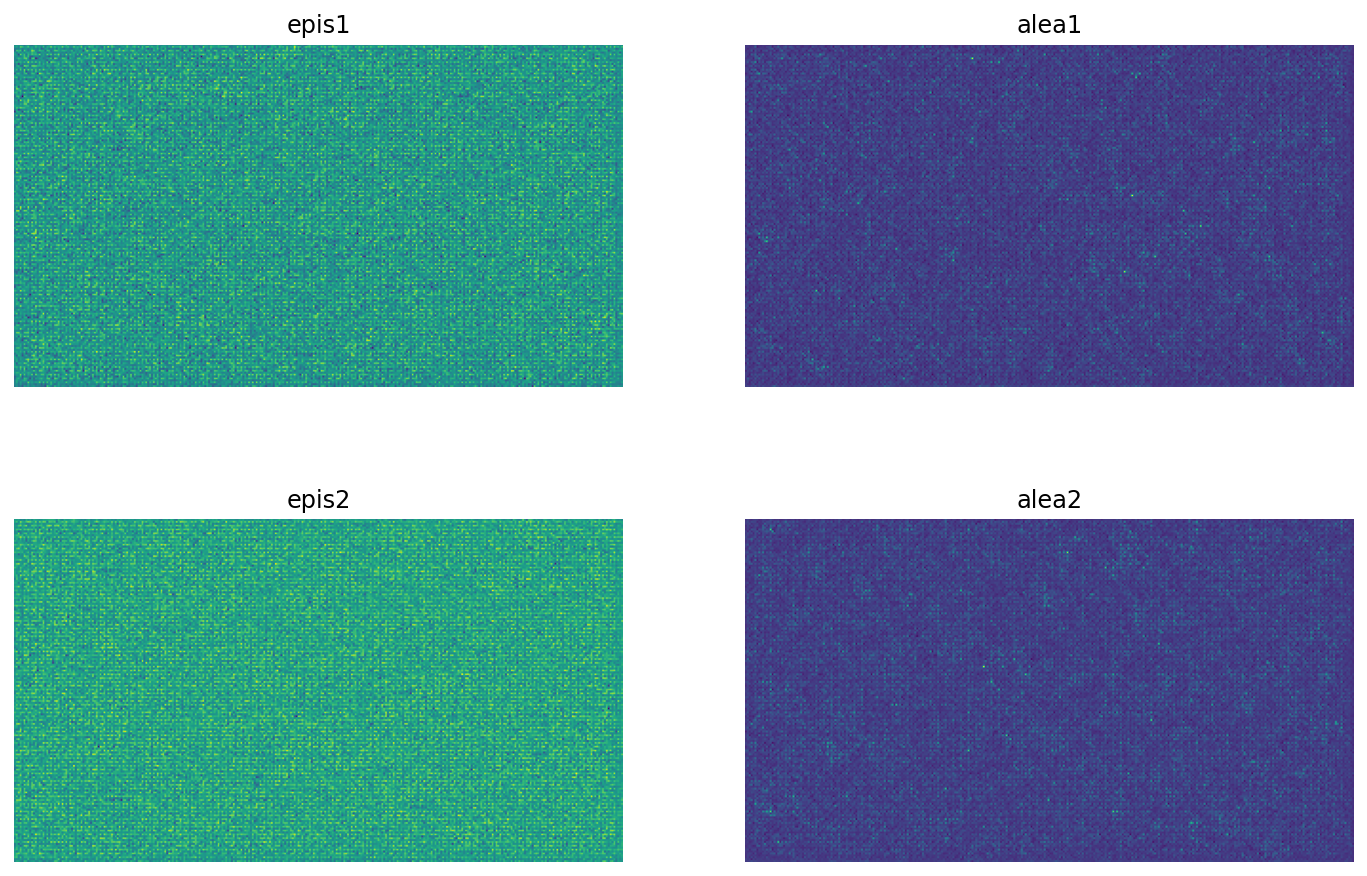

In [5]:
def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x H x W]
        :param sigma:   [N x K x H x W]
    """
    # $\pi$
    # todo: mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    mu_hat = torch.sigmoid(mu)  # [N x K x H x W], 지금은 D가 없음
    # $\pi$
    pi_usq = torch.unsqueeze(pi,     -1) # [N x K x 1]
    pi_exp = torch.unsqueeze(pi_usq, -1) # [N x K x 1 x 1]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp, mu_hat), dim=1, keepdim=True) # [N x 1 x H x W]
    mu_hat_diff_sq = torch.square(mu_hat - mu_hat_avg) # [N x K x H x W]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp, mu_hat_diff_sq), dim=1)  # [N x H x W]
    # todo: sum over D
    epis = torch.sqrt(epis) # [N x H x W]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp, sigma), dim=1)  # [N x H x W]
    # todo: sum over D
    alea = torch.sqrt(alea) # [N x H x W]
    # Return
    unct_out = {'epis':epis, # [N x H x W]
                'alea':alea  # [N x H x W]
                }
    return unct_out

def mace_loss(pi, mu, sigma, target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x H x W]
        :param sigma:   [N x K x H x W]
        :param target:  [N x 1 x H x W]
    """
    # $\mu$
    # todo: mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    mu_hat = torch.sigmoid(mu)  # 지금은 D가 없음
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x H x W]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,     -1) # [N x K x 1]
    pi_exp = torch.unsqueeze(pi_usq, -1) # [N x K x 1 x 1]
    # todo: pi는 지금 D가 없어서 expand 안 해줘도 됨
    # target
    target_exp = target.expand_as(mu)  # [N x K x H x W]
    # CE loss
    ce_exp = - target_exp * log_mu_hat # CE [N x K x H x W]
    
    ace_exp = ce_exp / sigma  # attenuated CE [N x K x H x W]
    mace_exp = torch.mul(pi_exp, ace_exp) # mixtured attenuated CE [N x K x H x W]
    mace = torch.sum(mace_exp, dim=1) # [N x H x W]
    # todo: sum over D
    mace_avg = torch.mean(mace)
    
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N x H x W]
    alea = unct_out['alea'] # [N x H x W]
    epis_avg = torch.mean(epis)
    alea_avg = torch.mean(alea)
    # Return
    loss_out = {'mace':mace, # [N x H x W]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N x H x W]
                'alea':alea, # [N x H x W]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_gather(pi, mu, sigma):  # K 개의 expert 중 하나 선택
    """
        :param pi:      [N x K]
        :param mu:      [N x K x H x W]
        :param sigma:   [N x K x H x W]
    """
    max_idx = torch.argmax(pi, dim=1) # [N]
    #todo: idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    idx_gather = max_idx.repeat(mu.shape[-2], mu.shape[-1], 1).permute(2, 0, 1).unsqueeze(dim=1)  # [N x 1 x H x W]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x H x W]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x H x W]
    out = {'max_idx':max_idx,       # [N]
           'idx_gather':idx_gather, # [N x 1 x H x W]
           'mu_sel':mu_sel,         # [N x H x W]
           'sigma_sel':sigma_sel    # [N x H x W]
           }
    return out

def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        model.eval() # evaluate (deactivates DropOut and BN)
        for i, (batch_in, batch_out) in enumerate(data_iter):
            if i == len(data_iter) // 10:
                break
            # Forward path
            y_trgt = batch_out.to(device)
            with torch.no_grad():
                mln_out = model(batch_in.to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out = mln_gather(pi,mu,sigma)
            model_pred = out['mu_sel'] # [N x H x W]

            # Compute uncertainty 
            unct_out = mln_uncertainties(pi,mu,sigma)
            epis_unct = unct_out['epis'] # [N x H x W]
            alea_unct = unct_out['alea'] # [N x H x W]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            # todo: _,y_pred = torch.max(model_pred,1)  # argmax
            y_pred = model_pred > .8  # threshold, [N x H x W]
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.numel() // 3  # N x H x W
        val_accr = (n_correct/n_total)
        epis = (epis_unct_sum/n_total).detach().cpu().item()
        alea = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr, 'epis':epis, 'alea':alea}
    return out_eval

# Demo forward path of MLN
# 걍 돌아가는지만 확인
M = MixtureLogitsNetwork(dim_k=10).to(device)
x = torch.randn(2, 3, 180, 320).to(device)
target = torch.randint(2, [2, 1, 180, 320]).to(device)
mln_out = M(x)
pi, mu, sigma = mln_out['pi'], mln_out['mu'], mln_out['sigma']
mu_sel = mln_gather(pi,mu,sigma)['mu_sel']
loss_out = mace_loss(pi,mu,sigma,target)
loss = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print (f'mace: [{loss_out["mace_avg"]:.3f}]')
# print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
#        (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))

plt.figure(figsize=(12,8))
plt.gcf().tight_layout() 
plt.subplot(221)
plt.title('epis1')
plt.imshow(tc2np(loss_out['epis'][0]))
plt.axis('off')
plt.subplot(222)
plt.title('alea1')
plt.imshow(tc2np(loss_out['alea'][0]))
plt.axis('off')

plt.subplot(223)
plt.title('epis2')
plt.imshow(tc2np(loss_out['epis'][1]))
plt.axis('off')
plt.subplot(224)
plt.title('alea2')
plt.imshow(tc2np(loss_out['alea'][1]))
plt.axis('off')
plt.show() 

### Dataset

In [6]:
from pathlib import Path
root = Path('./data/tusimple')
ptrain = root / 'train_set'
pimages = root / 'train_set_preprocessed/images'
plabels = root / 'train_set_preprocessed/labels'
boxes = [
    # left, top, right, bottom
    ( 80, 45, 240, 135),  # center
    (  0,  0, 160,  90),  # leftupper
    (  0, 90, 160, 180),  # leftbottom
    (160,  0, 320,  90),  # rightupper
    (160, 90, 320, 180),  # rightbottom
]
class TuSimpleDataset(torch.utils.data.Dataset):
    def __init__(self, p_crop=.4):
        super().__init__()
        self.p_crop = p_crop
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
        with open(pimages.parent / 'filenames.txt', 'r') as f:
            self.filenames = [Path(filename) for filename in f.read().split('\n') if filename]
            
    def __getitem__(self, index):
        filename = self.filenames[index]
        image = Image.open(pimages / filename.with_suffix('.jpg')).convert('RGB')
        label = np.load(plabels / filename.with_suffix('.npy'))
        
        if random.random() < self.p_crop:  # crop
            box = left, top, right, bottom = random.choice(boxes)
            image = image.crop(box).resize((320, 180))
            labelx = label[:,0]
            labely = label[:,1]
            idx = (left <= labelx) & (labelx < right) & (top  <= labely) & (labely < bottom)
            label = label[idx]
            label -= np.array([[left, top]])
            label *= 2
        
        tmp = np.zeros((320, 180))
        tmp[label[:,0], label[:,1]] = 1.
        label = tmp.T[None,:,:]  # 가로세로 왜 바꾼지는 모르겠는데 암튼 바껴있음
        return self.transform(image), label
    
    def __len__(self):
        return len(self.filenames)
    
def get_train_iter(BATCH_SIZE=32):
    tusimple_train = TuSimpleDataset()
    return torch.utils.data.DataLoader(tusimple_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)
def get_test_iter(BATCH_SIZE=1):
    # todo: 바꿔야 됨
    tusimple_train = TuSimpleDataset()
    return torch.utils.data.DataLoader(tusimple_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

### Evaluation

In [7]:
train_iter, test_iter = get_train_iter(), get_test_iter()
M = MixtureLogitsNetwork(dim_k=10, mu_min=-1, mu_max=+1, sig_min=0.1).to(device)
train_accr = func_eval(M, train_iter, device)['val_accr']
test_accr = 0
# test_accr = func_eval(M,test_iter, device)['val_accr']
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[21.498] test_accr:[0.000].


### Train

In [8]:
def train_wrapper(rs_rate=0.0,rp_rate=0.0,EPOCHS=10):
    np.set_printoptions(formatter={'float_kind':'{:.2f}'.format}) 
    M = MixtureLogitsNetwork(dim_k=10, mu_min=-1, mu_max=+1, sig_min=0.1).to(device)
    np.random.seed(seed=0)
    torch.manual_seed(seed=0) # fix random seed
    optm = optim.Adam(M.parameters(),lr=1e-3,weight_decay=1e-6)
    M.train() # train mode
    train_iter = get_train_iter(BATCH_SIZE=64)
    test_iter = get_test_iter(BATCH_SIZE=64)
    print_every = 1
    for epoch in range(EPOCHS):
        loss_sum = 0.0
        for batch_in, batch_out in train_iter:
            # Forward path
            mln_out = M(batch_in.to(device)) 
            pi, mu, sigma = mln_out['pi'], mln_out['mu'], mln_out['sigma']
            target = batch_out.to(device) 
            loss_out = mace_loss(pi, mu, sigma, target) # 'mace_avg','epis_avg','alea_avg'
            loss = loss_out['mace_avg'] - loss_out['epis_avg'] + loss_out['alea_avg']
            # Update 
            optm.zero_grad() # reset gradient 
            loss.backward() # back-propagation 
            optm.step() # optimizer update
            # Track losses 
            loss_sum += loss
        loss_avg = loss_sum/len(train_iter)
        # Print
        if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
            train_res = func_eval(M,train_iter,device)
            test_res  = func_eval(M,test_iter,device)
            print ("epoch:[%d/%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
                (epoch,EPOCHS,loss_avg,train_res['val_accr'],test_res['val_accr'])) 
            print (" [Train] alea:[%.3f] epis:[%.3f] / [Test] alea:[%.3f] epis:[%.3f]"%
                (train_res['alea'],train_res['epis'],test_res['alea'],test_res['epis']))
    out = {'M':M, 'train_iter':train_iter, 'test_iter':test_iter}
    return out 
print ("Done.")

Done.


In [9]:
out = train_wrapper()

epoch:[0/10] loss:[0.283] train_accr:[15.368] test_accr:[14.916].
 [Train] alea:[0.431] epis:[0.438] / [Test] alea:[0.434] epis:[0.436]
epoch:[3/10] loss:[-0.126] train_accr:[10.844] test_accr:[11.297].
 [Train] alea:[0.331] epis:[0.486] / [Test] alea:[0.332] epis:[0.486]
epoch:[6/10] loss:[-0.145] train_accr:[12.657] test_accr:[11.638].
 [Train] alea:[0.323] epis:[0.477] / [Test] alea:[0.323] epis:[0.482]
epoch:[9/10] loss:[-0.152] train_accr:[7.955] test_accr:[7.445].
 [Train] alea:[0.320] epis:[0.493] / [Test] alea:[0.320] epis:[0.493]


In [ ]:
M = out['M']

In [38]:
for image, target in get_test_iter(1):
    break
image = image.squeeze(0).permute(1, 2, 0).numpy()
image = np.uint8((image / 2 + .5) * 255)
target = target.squeeze().numpy()
target = np.uint8(target * 255)

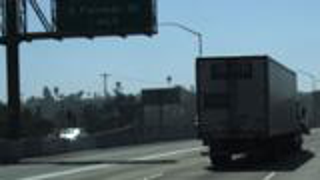

In [39]:
Image.fromarray(image) 

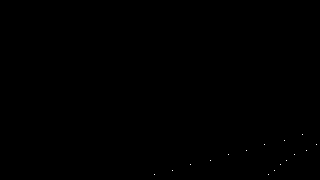

In [40]:
Image.fromarray(target) 